In [1]:
import pickle
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import sklearn
import re
from collections import Counter
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
with open("../data/190325_data.pkl", "rb") as f:
    chat_data = pickle.load(f)
    
# Remove service chat
del chat_data[-1000]

In [4]:
for i in range(3):
    game_id = random.choice(list(chat_data.keys()))
    while len(list(chat_data[game_id]['messages'])) == 0:
        game_id = random.choice(list(chat_data.keys()))
        
    message = random.choice(list(chat_data[game_id]['messages']))
    while message["userID"] == "GameMaster":
        message = random.choice(list(chat_data[game_id]['messages']))

    print(message)

{'gameID': 3750, 'oldidx': None, 'color': 'Blue', 'userID': 'OxIok9CEdREUMZkK', 'botID': 0, 'message': 'hi', 'create_time': datetime.datetime(2025, 1, 30, 8, 41, 2), 'colorID': 'blue400', 'messageidx': 23847}
{'gameID': 2612, 'oldidx': None, 'color': 'Yellow', 'userID': 'e3e486gOkMJ60vsN', 'botID': 0, 'message': 'hi everyone even the machine', 'create_time': datetime.datetime(2024, 9, 6, 13, 6, 20), 'colorID': 'yellow400', 'messageidx': 9810}
{'gameID': 2349, 'oldidx': None, 'color': 'Blue', 'userID': '0', 'botID': 1, 'message': 'was ist denn das für ein Ding? wie geht das Spiel eigentlich weiter?', 'create_time': datetime.datetime(2024, 9, 5, 14, 46, 19), 'colorID': 'blue400', 'messageidx': 5894}


In [5]:
messages = []
labels = []
game_ids = []
user_ids = []
languages = []
for game_id, game_data in chat_data.items():
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        messages.append(message["message"])
        labels.append([int(not message["botID"]), message["botID"]])
        game_ids.append(message["gameID"])
        user_ids.append(message["userID"])
        if game_data["language"] is None:
            languages.append("en")
        else:
            languages.append(game_data["language"])
        
print(len(messages))
print(len(labels))

22696
22696


In [6]:
print(np.unique(labels))

[0 1 2]


In [7]:
messages_by_humans = 0
messages_by_bots = 0
for label in labels:
    if label[0] == 1:
        messages_by_humans += 1
    else:
        messages_by_bots += 1

In [8]:
sumation = 0
for message in messages:
    sumation += len(message.split(" "))
print(f"Sum of all words: {sumation}")
print(f"Average length of a message: {sumation/len(messages):.2f}")

Sum of all words: 121020
Average length of a message: 5.33


In [9]:
word_counts = [len(message.split()) for message in messages]
word_counts.sort()

n = len(word_counts)
if n % 2 == 1:
    median = word_counts[n // 2]
else:
    median = (word_counts[n // 2 - 1] + word_counts[n // 2]) / 2

print(f"Median word count: {median}")
print(f"Shortest message: {min(word_counts)}")
print(f"Longest message: {max(word_counts)}")

Median word count: 4.0
Shortest message: 0
Longest message: 46


In [10]:
unsorted_word_counts = [len(message.split()) for message in messages]
print(messages[np.argmax(unsorted_word_counts)])
print(game_ids[np.argmax(unsorted_word_counts)])

its realy complicated, but basicly its a hash of the cd key and the bios info, then they used some crazy math to get the product key, dont think i can explain it beter, im a cs student but thats way to low level 4 me
2331


In [11]:
char_counts = np.array([len(m.replace(" ", "")) for m in messages])

average = np.mean(char_counts)
std_dev = np.std(char_counts, ddof=1)

print(f"Average: {average:.2f}, Standard Deviation: {std_dev:.2f}")

Average: 22.51, Standard Deviation: 20.11


In [12]:
print(f"Messages by humans: {messages_by_humans}")
print(f"Messages by bots: {messages_by_bots}")
print(f"Percent by humans: {messages_by_humans/len(labels)*100:.2f}")
print(f"Percent by bots: {messages_by_bots/len(labels)*100:.2f}")
print(f"Number of games: {len(chat_data.keys())}")

Messages by humans: 15753
Messages by bots: 6943
Percent by humans: 69.41
Percent by bots: 30.59
Number of games: 1559


In [13]:
english_messages = 0
german_messages = 0
for game_id, game_data in chat_data.items():
    m= []
    for message in game_data["messages"]:
        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                break
            else:
                continue
        m.append(message["message"])
    if game_data["language"] == "en":
        english_messages += len(m)
    if game_data["language"] == "de":
        german_messages += len(m)
print(f"Number of messages in german games: {german_messages}")
print(f"Number of messages in english games: {english_messages}")

Number of messages in german games: 9139
Number of messages in english games: 13070


In [14]:
from collections import Counter
import re

english_words = []
german_words = []

for message, lang in zip(messages, languages):
    words = re.findall(r'\b\w+\b', message.lower())

    if lang == "en":
        english_words.extend(words)
    elif lang == "de":
        german_words.extend(words)

# Count words
english_counter = Counter(english_words)
german_counter = Counter(german_words)

# Total words in each language
total_english = sum(english_counter.values())
total_german = sum(german_counter.values())

# Compute relative frequencies
english_common = [(word, count / total_english) for word, count in english_counter.most_common(10)]
german_common = [(word, count / total_german) for word, count in german_counter.most_common(10)]

print("Most common English words (relative frequency):", english_common)
print("Most common German words (relative frequency):", german_common)


Most common English words (relative frequency): [('you', 0.03495802363509973), ('i', 0.03232447462702529), ('the', 0.024624351638949788), ('a', 0.016964333458103845), ('is', 0.016710336345649966), ('what', 0.016389497887813485), ('to', 0.015052670980161489), ('are', 0.01437088925725897), ('blue', 0.012018073899791456), ('yellow', 0.011683867172878455)]
Most common German words (relative frequency): [('ich', 0.046818701116091044), ('du', 0.02570524650672291), ('wie', 0.02322260304068899), ('ist', 0.022277880305826524), ('hallo', 0.020168731874505668), ('was', 0.018081553739344405), ('das', 0.016477722119694175), ('bin', 0.015049652869320678), ('ihr', 0.013511732138149221), ('nicht', 0.011402583706828368)]


In [15]:
english_question_words = ["how", "where", "what", "why", "when", "who", "which", "whom", "does", "do", "is", "are", "can", "could", "would", "should"]
german_question_words = ["wie", "wo", "was", "warum", "wann", "wer", "welche", "wem", "ob", "ist", "sind", "kann", "könnte", "würde", "sollte"]

question_count = 0
english_question_count = 0
german_question_count = 0

english_messages = 0
german_messages = 0

for message, lang in zip(messages, languages):
    lower_msg = message.lower()

    if lang == "en":
        english_messages += 1
        if "?" in lower_msg or any(word in lower_msg for word in english_question_words):
            question_count += 1
            english_question_count += 1

    elif lang == "de":
        german_messages += 1
        if "?" in lower_msg or any(word in lower_msg for word in german_question_words):
            question_count += 1
            german_question_count += 1

total_messages = len(messages)

print(f"Number of questions asked: {question_count}")
print(f"Percentage of questions: {question_count / total_messages:.2%}")
print(f"English questions: {english_question_count} ({english_question_count / english_messages:.2%})")
print(f"German questions: {german_question_count} ({german_question_count / german_messages:.2%})")


Number of questions asked: 11501
Percentage of questions: 50.67%
English questions: 6896 (50.87%)
German questions: 4605 (50.39%)


In [16]:
english_question_words = ["how", "where", "what", "why", "when", "who", "which", "whom", "does", "do", "is", "are", "can", "could", "would", "should"]
german_question_words = ["wie", "wo", "was", "warum", "wann", "wer", "welche", "wem", "ob", "ist", "sind", "kann", "könnte", "würde", "sollte"]
question_words = english_question_words + german_question_words

question_count_human = 0
question_count_bot = 0
marked_question_count_bot = 0

human_message_count = 0
bot_message_count = 0
marked_question_count_human = 0

for message, user_id in zip(messages, user_ids):
    lower_msg = message.lower()

    if user_id[0] == "0":
        bot_message_count += 1
        if "?" in lower_msg or any(word in lower_msg for word in question_words):
            question_count_bot += 1
            if "?" in lower_msg:
                marked_question_count_bot += 1
    else:
        human_message_count += 1
        if "?" in lower_msg or any(word in lower_msg for word in question_words):
            question_count_human += 1
            if "?" in lower_msg:
                marked_question_count_human += 1

total_messages = len(messages)

print(f"Number of questions asked: {question_count_human + question_count_bot}")
print(f"Percentage of questions: {(question_count_bot + question_count_human) / total_messages:.2%}")
print(f"Bot questions: {question_count_bot} ({question_count_bot / bot_message_count:.2%})")
print(f"Bot questions ending in '?': {marked_question_count_bot} ({marked_question_count_bot / question_count_bot:.2%})")
print(f"Human questions: {question_count_human} ({question_count_human / human_message_count:.2%})")
print(f"Human questions ending in '?': {marked_question_count_human} ({marked_question_count_human / question_count_human:.2%})")


Number of questions asked: 12248
Percentage of questions: 53.97%
Bot questions: 4796 (67.54%)
Bot questions ending in '?': 3123 (65.12%)
Human questions: 7452 (47.78%)
Human questions ending in '?': 3457 (46.39%)


In [17]:

total_time_diff = 0
total_message_pairs = 0
english_messages = 0
german_messages = 0

for game_id, game_data in chat_data.items():
    m = []
    game_over = False

    for message in game_data["messages"]:
        if game_over:
            break

        if message["userID"] == "GameMaster":
            if "won" in message["message"] or "surrendered" in message["message"] or "canceled" in message["message"] or "lost" in message["message"] or "timed out" in message["message"] or "disconnected" in message["message"]:
                game_over = True
                continue
            else:
                continue 

        m.append(message)

    if len(m) < 2:
        continue

    m.sort(key=lambda x: x["create_time"])

    if game_data["language"] == "en":
        english_messages += len(m)
    elif game_data["language"] == "de":
        german_messages += len(m)

    for i in range(1, len(m)):
        t1 = m[i - 1]["create_time"]
        t2 = m[i]["create_time"]
        delta = (t2 - t1).total_seconds()

        total_time_diff += delta
        total_message_pairs += 1


if total_message_pairs > 0:
    average_time_to_respond = total_time_diff / total_message_pairs
else:
    average_time_to_respond = 0

print(f"Number of messages in German games: {german_messages}")
print(f"Number of messages in English games: {english_messages}")
print(f"Average time between responses: {average_time_to_respond:.2f} seconds")

Number of messages in German games: 9131
Number of messages in English games: 13060
Average time between responses: 13.24 seconds


In [19]:
print(len(np.unique(np.array(user_ids))))

628


In [20]:
nique_values, counts = np.unique(np.array(user_ids), return_counts=True)

Number of all messages 22696
Number of all users 629
Number of only human messages 15753
Number of only human users 628


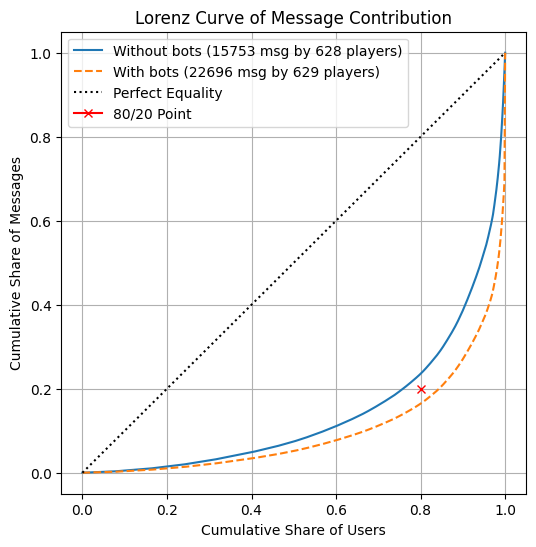

In [21]:
def lorenz_curve(data):
    sorted_data = np.sort(np.array(data))
    cum_data = np.cumsum(sorted_data)
    return np.insert(cum_data / cum_data[-1], 0, 0), np.linspace(0, 1, len(cum_data)+1)

lorenz_y_all, lorenz_x_all = lorenz_curve(counts)
lorenz_y, lorenz_x = lorenz_curve(counts[1:])
print(f"Number of all messages {sum(counts)}\nNumber of all users {len(lorenz_x_all)}")
lorenz_bot_y, lorenz_bot_x = lorenz_curve(counts[:3])
print(f"Number of only human messages {sum(counts[1:])}\nNumber of only human users {len(lorenz_x)}")

plt.figure(figsize=(6, 6))
plt.plot(lorenz_x, lorenz_y, label=f'Without bots ({sum(counts[1:])} msg by {len(lorenz_x)} players)')
plt.plot(lorenz_x_all, lorenz_y_all, label=f'With bots ({sum(counts)} msg by {len(lorenz_x_all)} players)', linestyle='--')
#plt.plot(lorenz_bot_x, lorenz_bot_y, label='Lorenz Curve only bots', linestyle='--')
plt.plot([0, 1], [0, 1], color='black', linestyle=':', label='Perfect Equality')
    
plt.plot(0.8, 0.2, marker='x', color='red', markersize=6, label='80/20 Point')

plt.xlabel("Cumulative Share of Users")
plt.ylabel("Cumulative Share of Messages")
plt.title("Lorenz Curve of Message Contribution")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
english_words = []
german_words = []

for message, lang in zip(messages, languages):
    words = re.findall(r'\b\w+\b', message.lower())

    if lang == "en":
        english_words.extend(words)
    elif lang == "de":
        german_words.extend(words)

english_common_50 = Counter(english_words).most_common(20)
german_common_50 = Counter(german_words).most_common(20)

In [ ]:
message_lengths = [len(msg.split()) for msg in messages]
message_lengths_bots = [len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]=='0']
message_lengths_humans = [len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]!='0']

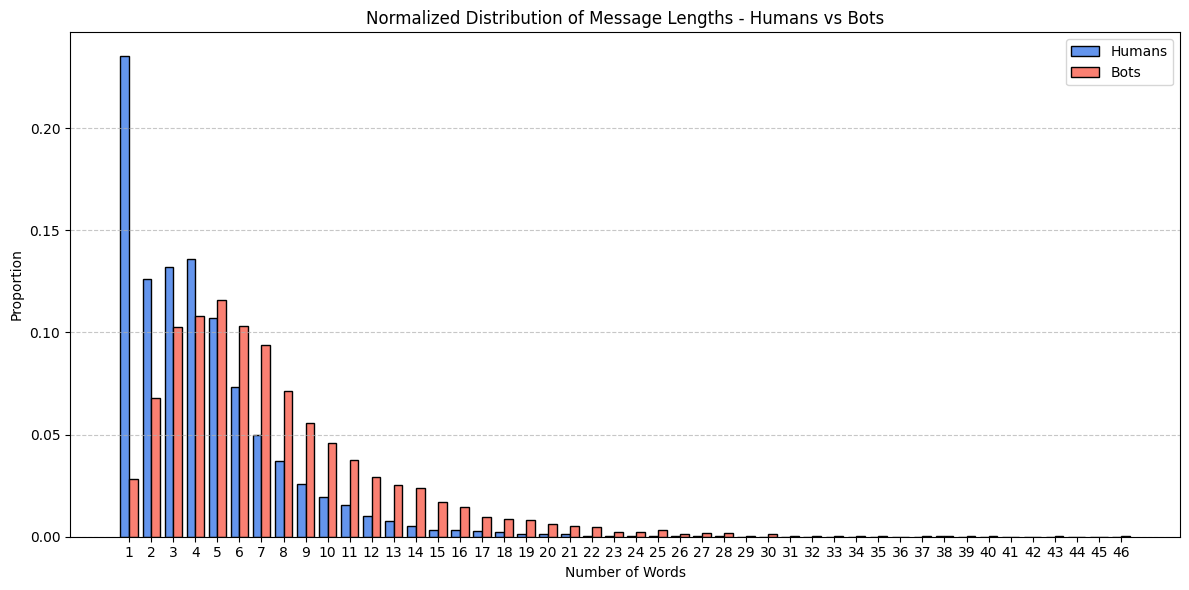

In [28]:
import numpy as np
import matplotlib.pyplot as plt

max_len = max(max(message_lengths_humans), max(message_lengths_bots))
bins = range(1, max_len + 2)

hist_h, _ = np.histogram(message_lengths_humans, bins=bins)
hist_b, _ = np.histogram(message_lengths_bots, bins=bins)

hist_h = hist_h / hist_h.sum()
hist_b = hist_b / hist_b.sum()

x = np.arange(1, max_len + 1)
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, hist_h, width=width, color="cornflowerblue", label="Humans", edgecolor="black")
plt.bar(x + width/2, hist_b, width=width, color="salmon", label="Bots", edgecolor="black")

plt.title("Normalized Distribution of Message Lengths - Humans vs Bots")
plt.xlabel("Number of Words")
plt.ylabel("Proportion")
plt.xticks(range(1, max_len + 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


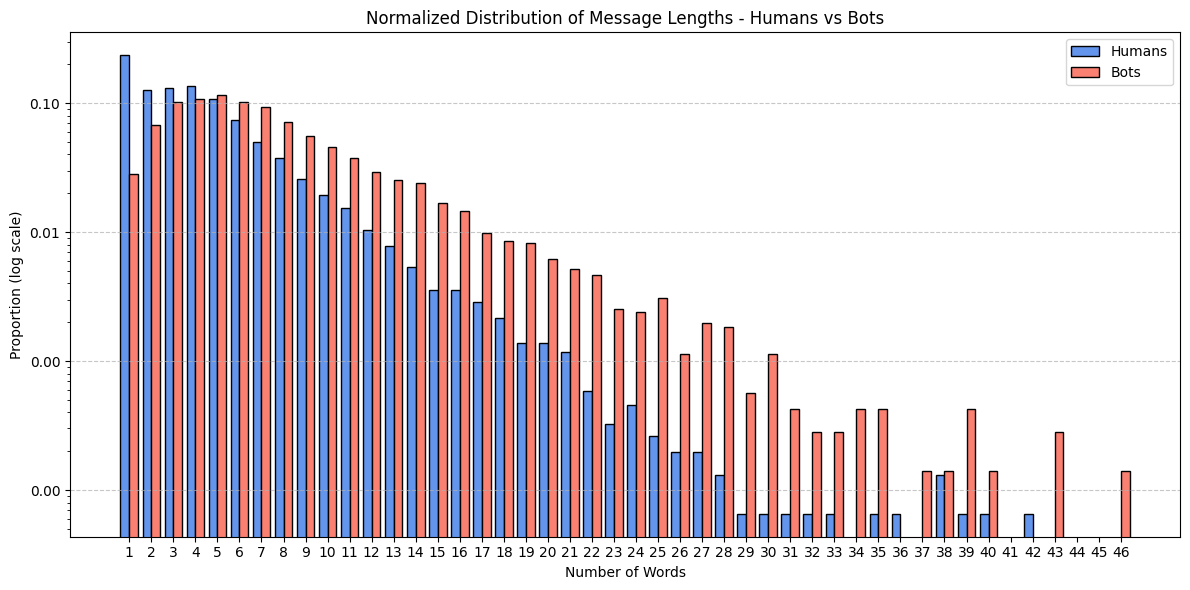

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

max_len = max(max(message_lengths_humans), max(message_lengths_bots))
bins = range(1, max_len + 2)

hist_h, _ = np.histogram(message_lengths_humans, bins=bins)
hist_b, _ = np.histogram(message_lengths_bots, bins=bins)

hist_h = hist_h / hist_h.sum()
hist_b = hist_b / hist_b.sum()

x = np.arange(1, max_len + 1)
width = 0.4

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, hist_h, width=width, color="cornflowerblue", label="Humans", edgecolor="black")
plt.bar(x + width/2, hist_b, width=width, color="salmon", label="Bots", edgecolor="black")

plt.title("Normalized Distribution of Message Lengths - Humans vs Bots")
plt.xlabel("Number of Words")
plt.ylabel("Proportion (log scale)")
plt.yscale("log")

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.2f}"))

plt.xticks(range(1, max_len + 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
s = pd.Series([len(msg.split()) for msg in messages])
s.describe()
print(s.mode())


0    1
dtype: int64


In [31]:
print("For bots:")
s = pd.Series([len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]=='0'])
print(s.describe())
print(s.mode())

For bots:
count    7101.000000
mean        7.505140
std         5.121442
min         1.000000
25%         4.000000
50%         6.000000
75%        10.000000
max        46.000000
dtype: float64
0    5
dtype: int64


In [32]:
print("For humans:")
s = pd.Series([len(msg.split()) for msg, user_id in zip(messages, user_ids) if user_id[0]!='0'])
print(s.describe())
print(s.mode())

For humans:
count    15595.000000
mean         4.217313
std          3.556381
min          0.000000
25%          1.500000
50%          3.000000
75%          6.000000
max         42.000000
dtype: float64
0    1
dtype: int64


In [33]:
punctuation_list = ["?"]
print("Fraction of messages ending in punctuation for bots")
print(sum(1 if len(msg)>0 and msg[-1] in punctuation_list else 0 for msg, user_id in zip(messages, user_ids) if user_id[0]=='0')/sum(1 for msg, user_id in zip(messages, user_ids) if user_id[0]=='0'))

Fraction of messages ending in punctuation for bots
0.4207858048162231


In [34]:
print("Fraction of messages ending in punctuation for humans")
print(sum(1 if len(msg)>0 and msg[-1] in punctuation_list else 0 for msg, user_id in zip(messages, user_ids) if user_id[0]!='0')/sum(1 for msg, user_id in zip(messages, user_ids) if user_id[0]!='0'))

Fraction of messages ending in punctuation for humans
0.2026290477717217
